*Import libraries*

In [ ]:
import os
from tqdm import tqdm
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import skimage.transform
import itertools
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils import class_weight
from imblearn.under_sampling import RandomUnderSampler

import keras
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.utils.np_utils import to_categorical
from keras.callbacks import Callback

import warnings

warnings.filterwarnings("ignore")

# Define and create output areas to keep your C drive clean
OUTPUT_DIR = "../models/output"
MODEL_DIR = os.path.join(OUTPUT_DIR, "models")
LOG_DIR = os.path.join(OUTPUT_DIR, "logs")

for folder in [MODEL_DIR, LOG_DIR]:
    if not os.path.exists(folder):
        os.makedirs(folder)

*Step 2*

In [4]:
train_dir = "../data/chest_xray/chest_xray/train/"
test_dir = "../data/chest_xray/chest_xray/test/"


def get_data(folder):
    X, y = [], []
    for folderName in os.listdir(folder):
        if not folderName.startswith("."):
            label = 0 if folderName == "NORMAL" else 1
            for image_filename in tqdm(os.listdir(os.path.join(folder, folderName))):
                img_path = os.path.join(folder, folderName, image_filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    X.append(img)
                    y.append(label)
    return np.asarray(X), np.asarray(y)


X_train, y_train = get_data(train_dir)
X_test, y_test = get_data(test_dir)

100%|██████████| 390/390 [00:45<00:00,  8.49it/s]


*Step 3*

In [5]:
class MetricsCheckpoint(Callback):
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)


def plotKerasLearningCurve():
    plt.figure(figsize=(10, 5))
    try:
        log_file = os.path.join(LOG_DIR, "training_metrics.npy")
        metrics = np.load(log_file, allow_pickle=True).item()
        filt = ["acc", "accuracy"]
        for k in filter(lambda x: np.any([kk in x for kk in filt]), metrics.keys()):
            l = np.array(metrics[k])
            plt.plot(l, label=k)
        plt.legend()
        plt.grid()
        plt.title("Learning Curve")
    except Exception as e:
        print(f"Could not plot logs: {e}")


def plot_confusion_matrix(cm, classes, title="Confusion matrix"):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()

*Step 4*

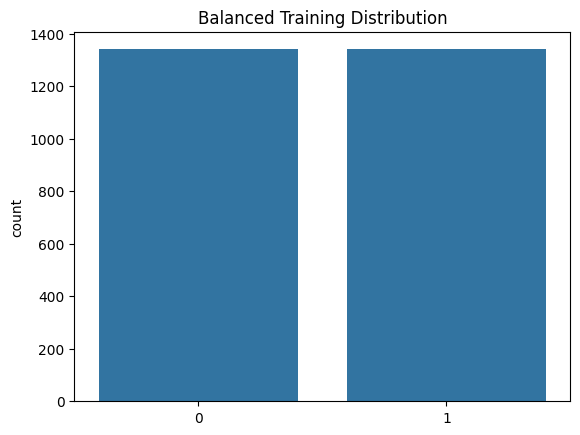

In [6]:
X_trainFlat = X_train.reshape(X_train.shape[0], -1)
rus = RandomUnderSampler(sampling_strategy="auto")
X_trainRos, Y_trainRos = rus.fit_resample(X_trainFlat, y_train)

# Reshape back to Images and Categorical
X_trainRosReshaped = X_trainRos.reshape(-1, 150, 150, 3)
Y_trainRosHot = to_categorical(Y_trainRos, num_classes=2)
Y_testHot = to_categorical(y_test, num_classes=2)

sns.countplot(x=Y_trainRos)
plt.title("Balanced Training Distribution")
plt.show()

*Step 5*

58889256/58889256 [==============================] - 65s 1us/step
Epoch 1/6
84/84 [==============================] - 158s 2s/step - loss: 0.4073 - accuracy: 0.8885 - val_loss: 0.3784 - val_accuracy: 0.8654
Epoch 2/6
84/84 [==============================] - 145s 2s/step - loss: 0.2334 - accuracy: 0.9366 - val_loss: 0.3128 - val_accuracy: 0.8910
Epoch 3/6
84/84 [==============================] - 125s 1s/step - loss: 0.1784 - accuracy: 0.9441 - val_loss: 0.3109 - val_accuracy: 0.8670
Epoch 4/6
84/84 [==============================] - 123s 1s/step - loss: 0.1480 - accuracy: 0.9545 - val_loss: 0.3360 - val_accuracy: 0.8510
Epoch 5/6
84/84 [==============================] - 127s 2s/step - loss: 0.1315 - accuracy: 0.9586 - val_loss: 0.3171 - val_accuracy: 0.8638
Epoch 6/6
20/20 [==============================] - 28s 1s/step
              precision    recall  f1-score   support

      NORMAL       0.97      0.62      0.76       234
   PNEUMONIA       0.81      0.99      0.89       390

    acc

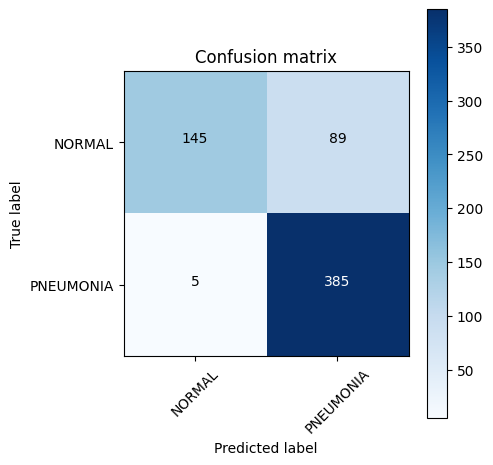

In [7]:
def pretrainedNetwork(xtrain, ytrain, xtest, ytest, pretrainedmodel, numclasses, numepochs, optimizer, labels, model_name):
    base_model = pretrainedmodel
    x = Flatten()(base_model.output)
    predictions = Dense(numclasses, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    # Redirect logs to the specific output folder
    log_path = os.path.join(LOG_DIR, "training_metrics")
    
    history = model.fit(
        xtrain, ytrain,
        epochs=numepochs,
        validation_data=(xtest, ytest),
        verbose=1,
        callbacks=[MetricsCheckpoint(log_path)],
    )

    # Save the resulting model to the local model folder
    model.save(os.path.join(MODEL_DIR, model_name))

    # Evaluation
    y_pred = model.predict(xtest)
    Y_pred_classes = np.argmax(y_pred, axis=1)
    Y_true = np.argmax(ytest, axis=1)

    print(classification_report(Y_true, Y_pred_classes, target_names=list(labels.values())))
    plot_confusion_matrix(confusion_matrix(Y_true, Y_pred_classes), classes=list(labels.values()))
    plt.show()
    return model

# Initialize VGG16
vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
opt = keras.optimizers.RMSprop(learning_rate=0.0001)
map_labels = {0: "NORMAL", 1: "PNEUMONIA"}

# Execute Final Training
final_model = pretrainedNetwork(
    X_trainRosReshaped, Y_trainRosHot, 
    X_test, Y_testHot, 
    vgg_base, 2, 6, opt, map_labels, "vgg16_pneumonia.h5"
)


*STEP 6*

20/20 [==============================] - 27s 1s/step


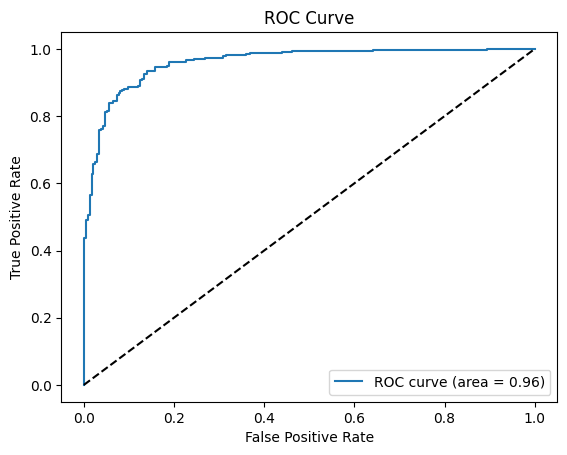

In [8]:
y_pred_probs = final_model.predict(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()